# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from matplotlib import rcParams

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.model import ModelRunner

# Import dataset

In [2]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

# Path to database directory
DB_DIR = bconf.DB_DIR

# Path to the DuckDB instance:
# "osbad/database/train_dataset_severson.db"
db_filepath = (
    DB_DIR.joinpath("train_dataset_severson.db"))

## Get unique cell labels from training dataset

In [3]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_train_dataset_sv").fetchdf()

unique_cell_index_train = df_duckdb["cell_index"].unique()
print(unique_cell_index_train)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

['2017-05-12_5_4C-50per_3C_CH13' '2017-05-12_5_4C-50per_3C_CH14'
 '2017-05-12_5_4C-60per_3C_CH15' '2017-05-12_5_4C-60per_3C_CH16'
 '2017-05-12_5_4C-70per_3C_CH17' '2017-05-12_5_4C-70per_3C_CH18'
 '2017-05-12_6C-40per_3C_CH25' '2017-05-12_6C-40per_3C_CH26'
 '2017-05-12_6C-50per_3C_CH27' '2017-05-12_6C-50per_3C_CH28'
 '2017-05-12_6C-60per_3C_CH29' '2017-05-12_6C-60per_3C_CH30'
 '2017-05-12_7C-40per_3C_CH37' '2017-05-12_7C-40per_3C_CH38'
 '2017-05-12_4C-80per_4C_CH5' '2017-05-12_4C-80per_4C_CH6'
 '2017-05-12_4_4C-80per_4_4C_CH7' '2017-05-12_5_4C-80per_5_4C_CH11'
 '2017-05-12_5_4C-80per_5_4C_CH12' '2017-05-12_3_6C-80per_3_6C_CH1'
 '2017-05-12_3_6C-80per_3_6C_CH2' '2017-05-12_3_6C-80per_3_6C_CH3'
 '2017-05-12_5_4C-40per_3_6C_CH19']


In [4]:
training_cell_count = len(unique_cell_index_train)
print(f"Training cell count: {training_cell_count}")

Training cell count: 23


## Define selected_cell_label

In [5]:
# Get the cell-ID from cell_inventory
selected_cell_label = "2017-05-12_5_4C-70per_3C_CH17"

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

# Load benchmarking dataset

In [6]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************


## Drop labels

In [7]:
if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)

    # print a subset of the dataframe
    # for diagnostics running in terminals
    print(df_selected_cell_without_labels.head(10).to_markdown())
    print("*"*100)

|    | cell_index                    |   cycle_index |   discharge_capacity |   voltage |
|---:|:------------------------------|--------------:|---------------------:|----------:|
|  0 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          1.26512e-05 |   3.29189 |
|  1 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00136774  |   3.28185 |
|  2 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00292998  |   3.27788 |
|  3 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  4 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  5 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00605927  |   3.27299 |
|  6 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00762155  |   3.27124 |
|  7 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.0091859   |   3.2703  |
|  8 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.0107469   |   3.26875 |
|  9 | 201

## Plot cycle data without labels

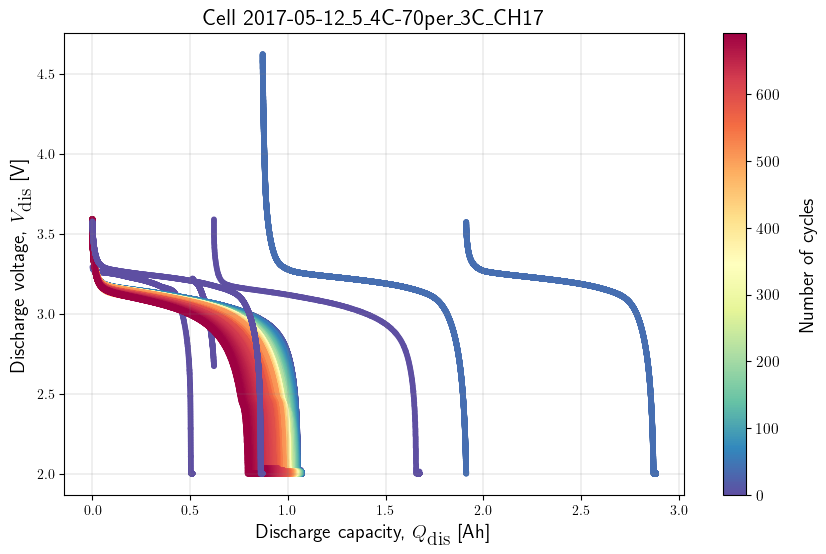

In [8]:
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels)

output_fig_filename = (
    "cycle_data_without_labels_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Features transformation

## Load the training features dataset

In [8]:
# Define the filepath to ``train_features_severson.db``
# osbad/database/train_features_severson.db
db_features_filepath = (
    DB_DIR.joinpath(
        "train_features_severson.db"))

# Load only the training features dataset
df_features_per_cell = benchdb.load_features_db(
    db_features_filepath,
    dataset_type="train")

unique_cycle_count = (
    df_features_per_cell["cycle_index"].unique())

Features database is found in the given filepath.
Features database is loaded.
****************************************************************************************************


In [9]:
df_features_per_cell

,max_diff_dQ,log_max_diff_dQ,cycle_index,max_diff_dV,log_max_diff_dV,cell_index
0,0.006388,-5.053343,0.0,1.564151,0.447343,2017-05-12_5_4C-70per_3C_CH17
1,0.006338,-5.061258,1.0,0.023727,-3.741163,2017-05-12_5_4C-70per_3C_CH17
2,0.006321,-5.063922,2.0,0.022684,-3.786091,2017-05-12_5_4C-70per_3C_CH17
3,0.006259,-5.073756,3.0,0.027899,-3.579172,2017-05-12_5_4C-70per_3C_CH17
4,0.006236,-5.077346,4.0,0.026408,-3.634081,2017-05-12_5_4C-70per_3C_CH17
...,...,...,...,...,...,...
687,0.006236,-5.077391,687.0,0.046420,-3.070023,2017-05-12_5_4C-70per_3C_CH17
688,0.006281,-5.070178,688.0,0.051542,-2.965352,2017-05-12_5_4C-70per_3C_CH17
689,0.006243,-5.076238,689.0,0.047776,-3.041228,2017-05-12_5_4C-70per_3C_CH17
690,0.006316,-5.064619,690.0,0.046331,-3.071935,2017-05-12_5_4C-70per_3C_CH17


# Hyperparameter tuning

## Create optuna study

In [10]:
hp_config_knn = {
    "contamination": {"low": 0.0, "high": 0.5},
    "n_neighbors": {"low": 2, "high": 50},
    "method": ["largest","mean","median"],
    "metric": ["minkowski","euclidean","manhattan"],
    "threshold": {"low": 0.0, "high": 1.0}
}

knn_hp_config_filepath = (
    Path.cwd()
    .parents[3]
    .joinpath(
        "machine_learning",
        "hp_config_schema",
        "severson_hp_config",
        "knn_hp_config.json"))

bconf.create_json_hp_config(
    knn_hp_config_filepath,
    hp_dict=hp_config_knn)

bconf.load_json_hp_config(
    knn_hp_config_filepath)

{'contamination': {'low': 0.0, 'high': 0.5},
 'n_neighbors': {'low': 2, 'high': 50},
 'method': ['largest', 'mean', 'median'],
 'metric': ['minkowski', 'euclidean', 'manhattan'],
 'threshold': {'low': 0.0, 'high': 1.0}}

In [11]:
# Reload the hp module to refresh in-memory variables
# especially after updating parameters
from importlib import reload
reload(hp)

# Check if the schema in the script has been updated 
# based on the current constraints specified 
# from the notebook
print("Current hyperparameter config:")
print(hp._KNN_HP_CONFIG)
print("-"*70)

# Instantiate an optuna study for knn model
sampler = optuna.samplers.TPESampler(seed=42)

selected_feature_cols = (
    "cycle_index",
    "log_max_diff_dQ",
    "log_max_diff_dV")

knn_study = optuna.create_study(
    study_name="knn_hyperparam",
    sampler=sampler,
    directions=["minimize","maximize"])

knn_study.optimize(
    lambda trial: hp.objective(
        trial,
        model_id="knn",
        df_feature_dataset=df_features_per_cell,
        selected_feature_cols=selected_feature_cols,
        #df_benchmark_dataset=df_selected_cell,
        selected_cell_label=selected_cell_label),
    n_trials=100)

[I 2025-10-13 13:05:03,660] A new study created in memory with name: knn_hyperparam


Current hyperparameter config:
{'contamination': {'low': 0.0, 'high': 0.5}, 'n_neighbors': {'low': 2, 'high': 50}, 'method': ['largest', 'mean', 'median'], 'metric': ['minkowski', 'euclidean', 'manhattan'], 'threshold': {'low': 0.0, 'high': 1.0}}
----------------------------------------------------------------------


[I 2025-10-13 13:05:03,955] Trial 0 finished with values: [0.33733236991965365, 0.9971098265895953] and parameters: {'contamination': 0.18727005942368125, 'n_neighbors': 48, 'method': 'largest', 'metric': 'manhattan', 'threshold': 0.6011150117432088}.
[I 2025-10-13 13:05:04,022] Trial 1 finished with values: [0.33733236991965365, 0.9971098265895953] and parameters: {'contamination': 0.35403628889802274, 'n_neighbors': 3, 'method': 'largest', 'metric': 'manhattan', 'threshold': 0.5247564316322378}.
[I 2025-10-13 13:05:04,077] Trial 2 finished with values: [0.200664623866367, 0.9942196531791907] and parameters: {'contamination': 0.21597250932105788, 'n_neighbors': 16, 'method': 'largest', 'metric': 'manhattan', 'threshold': 0.19967378215835974}.
[I 2025-10-13 13:05:04,144] Trial 3 finished with values: [0.33733236991965365, 0.9971098265895953] and parameters: {'contamination': 0.2571172192068058, 'n_neighbors': 31, 'method': 'mean', 'metric': 'manhattan', 'threshold': 0.8083973481164611}

## Aggregate best trials

In [12]:
schema_knn = {
    "contamination": "median",
    "n_neighbors": "median_int",
    "method": "mode",
    "metric": "mode",
    "threshold": "median",
}

trade_off_trials_list = hp.trade_off_trials_detection(
    knn_study, 
    window_size=7)

df_knn_hyperparam = hp.aggregate_best_trials(
    trade_off_trials_list,
    cell_label=selected_cell_label,
    model_id="knn",
    schema=schema_knn)

df_knn_hyperparam

,ml_model,cell_index,contamination,n_neighbors,method,metric,threshold
0,knn,2017-05-12_5_4C-70per_3C_CH17,0.18492,22,largest,minkowski,0.199195


## Plot pareto front

/home/basf/nasbattds/osbad/src/osbad/hyperparam.py:1027: ExperimentalWarning: optuna.visualization.matplotlib._pareto_front.plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  axplot = optuna.visualization.matplotlib.plot_pareto_front(


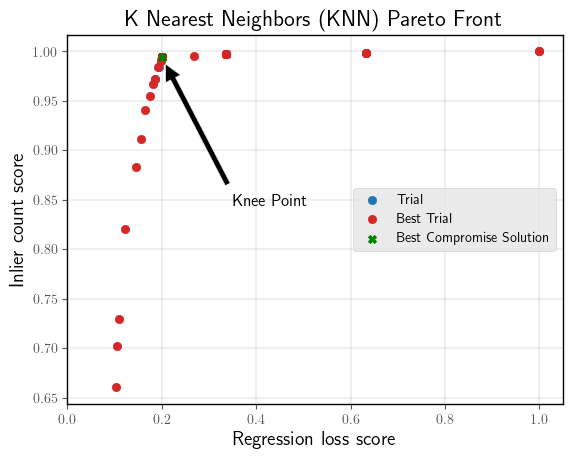

In [13]:
hp.plot_proxy_pareto_front(
    knn_study,
    trade_off_trials_list,
    selected_cell_label,
    fig_title="K Nearest Neighbors (KNN) Pareto Front")

plt.show()

## Export current hyperparameters to CSV 

In [14]:
# Export current hyperparameters to CSV
hyperparam_filepath =  Path.cwd().joinpath(
    "ml_02_knn_hyperparam_proxy_severson.csv")

hp.export_current_hyperparam(
    df_knn_hyperparam,
    selected_cell_label,
    export_csv_filepath=hyperparam_filepath,
    if_exists="replace")

Creating new row for cell 2017-05-12_5_4C-70per_3C_CH17.
Hyperparameters for 2017-05-12_5_4C-70per_3C_CH17 have been created in the CSV file.


,ml_model,cell_index,contamination,n_neighbors,method,metric,threshold
0,knn,2017-05-12_5_4C-70per_3C_CH17,0.18492,22,largest,minkowski,0.199195


# Train model with best trial parameters

## Load best trial parameters from CSV output

In [15]:
# Test reading from exported metrics
df_hyperparam_from_csv = pd.read_csv(hyperparam_filepath)

df_param_per_cell = df_hyperparam_from_csv[
    df_hyperparam_from_csv["cell_index"] == selected_cell_label]
df_param_per_cell

,ml_model,cell_index,contamination,n_neighbors,method,metric,threshold
0,knn,2017-05-12_5_4C-70per_3C_CH17,0.18492,22,largest,minkowski,0.199195


## Create a dict for best trial parameters

In [16]:
param_dict = df_param_per_cell.iloc[0].to_dict()
pprint.pp(param_dict)

{'ml_model': 'knn',
 'cell_index': '2017-05-12_5_4C-70per_3C_CH17',
 'contamination': 0.18492006543856784,
 'n_neighbors': 22,
 'method': 'largest',
 'metric': 'minkowski',
 'threshold': 0.19919473184626607}


## Run the model with best trial parameters

In [17]:
cfg = hp.MODEL_CONFIG["knn"]

selected_feature_cols = (
    "log_max_diff_dQ",
    "log_max_diff_dV")

runner = ModelRunner(
    cell_label=selected_cell_label,
    df_input_features=df_features_per_cell,
    selected_feature_cols=selected_feature_cols
)

Xdata = runner.create_model_x_input()

model = cfg.model_param(param_dict)
print(model)
model.fit(Xdata)
proba = model.predict_proba(Xdata)

pred_outlier_indices, pred_outlier_score = runner.pred_outlier_indices_from_proba(
    proba=proba,
    threshold=param_dict["threshold"],
    outlier_col=cfg.proba_col
)

pred_outlier_indices, pred_outlier_score

KNN(algorithm='auto', contamination=0.18492006543856784, leaf_size=30,
  method='largest', metric='minkowski', metric_params=None, n_jobs=-1,
  n_neighbors=22, p=2, radius=1.0)


(array([  0,  40, 147, 148]),
 array([0.87126609, 0.99943761, 0.47183989, 0.47458485]))

## Get df_outliers_pred

In [18]:
df_outliers_pred = (df_features_per_cell[
    df_features_per_cell["cycle_index"]
    .isin(pred_outlier_indices)].copy())

df_outliers_pred["outlier_prob"] = pred_outlier_score
df_outliers_pred

,max_diff_dQ,log_max_diff_dQ,cycle_index,max_diff_dV,log_max_diff_dV,cell_index,outlier_prob
0,0.006388,-5.053343,0.0,1.564151,0.447343,2017-05-12_5_4C-70per_3C_CH17,0.871266
40,0.006305,-5.066425,40.0,2.612268,0.960219,2017-05-12_5_4C-70per_3C_CH17,0.999438
147,0.042814,-3.150895,147.0,0.029431,-3.525697,2017-05-12_5_4C-70per_3C_CH17,0.471840
148,0.042899,-3.148905,148.0,0.025238,-3.679404,2017-05-12_5_4C-70per_3C_CH17,0.474585


## Predict anomaly score map

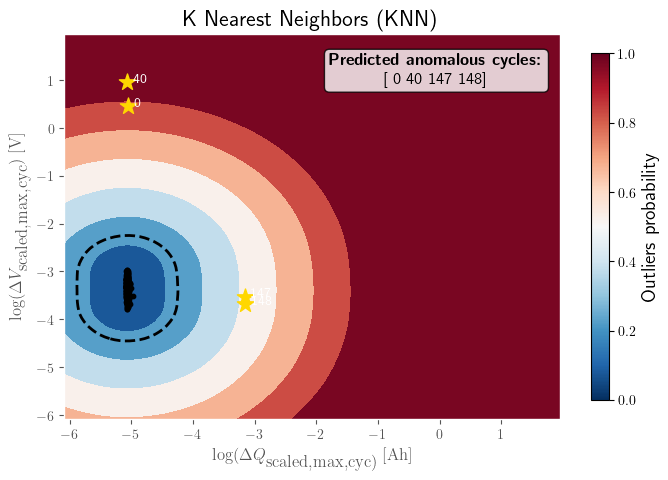

In [19]:
axplot = runner.predict_anomaly_score_map(
    selected_model=model,
    model_name="K Nearest Neighbors (KNN)",
    xoutliers=df_outliers_pred["log_max_diff_dQ"],
    youtliers=df_outliers_pred["log_max_diff_dV"],
    pred_outliers_index=pred_outlier_indices,
    threshold=param_dict["threshold"]
)

axplot.set_xlabel(
    r"$\log(\Delta Q_\textrm{scaled,max,cyc)}\;\textrm{[Ah]}$",
    fontsize=12)
axplot.set_ylabel(
    r"$\log(\Delta V_\textrm{scaled,max,cyc})\;\textrm{[V]}$",
    fontsize=12)

output_fig_filename = (
    "knn_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Model performance evaluation

In [20]:
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)

## Confusion matrix

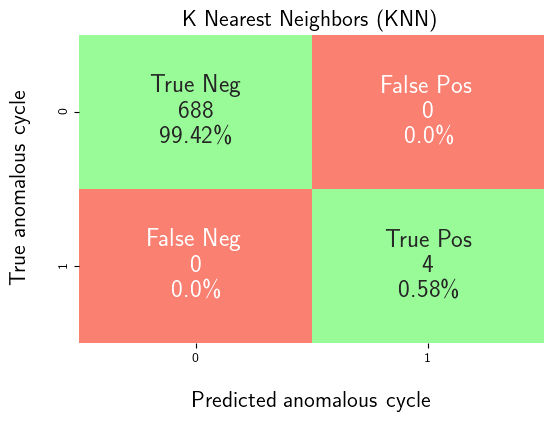

In [21]:
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "K Nearest Neighbors (KNN)",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_knn_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Evaluate model performance

In [22]:
df_current_eval_metrics = modval.eval_model_performance(
    model_name="knn",
    selected_cell_label=selected_cell_label,
    df_eval_outliers=df_eval_outlier)

df_current_eval_metrics

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
MCC-score: 1.0
****************************************************************************************************


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,knn,2017-05-12_5_4C-70per_3C_CH17,1.0,1.0,1.0,1.0,1.0


## Export model performance metrics to CSV output

In [23]:
# Export current metrics to CSV
hyperparam_eval_filepath =  Path.cwd().joinpath(
    "eval_metrics_hp_single_cell_severson.csv")

hp.export_current_model_metrics(
    model_name="knn",
    selected_cell_label=selected_cell_label,
    df_current_eval_metrics=df_current_eval_metrics,
    export_csv_filepath=hyperparam_eval_filepath,
    if_exists="replace")

Have the metrics for knn on cell 2017-05-12_5_4C-70per_3C_CH17 been evaluated before?
False
----------------------------------------------------------------------
Creating new row for knn, 2017-05-12_5_4C-70per_3C_CH17.
Metrics for knn, 2017-05-12_5_4C-70per_3C_CH17 have been created in the CSV file.


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,iforest,2017-05-12_5_4C-70per_3C_CH17,1.0,1.0,1.0,1.0,1.0
1,knn,2017-05-12_5_4C-70per_3C_CH17,1.0,1.0,1.0,1.0,1.0


# Finally: check with true labels

## Plot cycle data with labels

True outlier cycle index:
[  0.  40. 147. 148.]


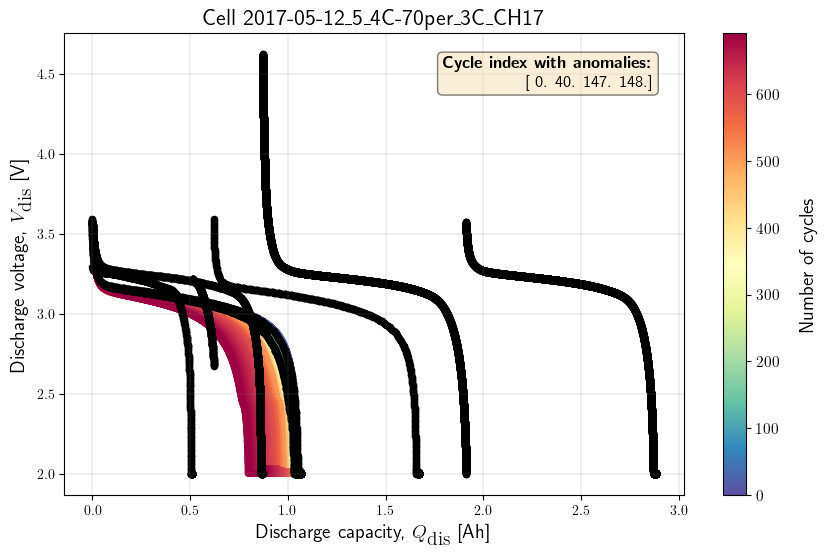

In [26]:
# Extract true outliers cycle index from benchmarking dataset
true_outlier_cycle_index = benchdb.get_true_outlier_cycle_index(
    df_selected_cell)
print(f"True outlier cycle index:")
print(true_outlier_cycle_index)

# Plot cell data with true anomalies
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels,
    true_outlier_cycle_index)

output_fig_filename = (
    "cycle_data_with_labels_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir.joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Calculate bubble size ratio

In [27]:
# Calculate the bubble size ratio for plotting
df_bubble_size_dQ = bviz.calculate_bubble_size_ratio(
    df_variable=df_features_per_cell["max_diff_dQ"])

df_bubble_size_dV = bviz.calculate_bubble_size_ratio(
    df_variable=df_features_per_cell["max_diff_dV"])

bubble_size = (
    np.abs(df_bubble_size_dV)
    * np.abs(df_bubble_size_dQ))

Feature mean: 0.00641125672398844
Feature max: 0.042899057000000074
Feature min: 0.006194469999999952
Feature std: 0.0019646872892444154
**********************************************************************
Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************


## Plot the bubble chart and label the true outliers

Potential anomalous cycle: 0.0
x-position of the text: -5.053343441284631
y-position of the text: 0.44734305691240445
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: -5.066424997988364
y-position of the text: 0.9602189626435208
----------------------------------------------------------------------
Potential anomalous cycle: 147.0
x-position of the text: -3.1508950320267735
y-position of the text: -3.5256965450993665
----------------------------------------------------------------------
Potential anomalous cycle: 148.0
x-position of the text: -3.1489054346417387
y-position of the text: -3.6794044837514233
----------------------------------------------------------------------


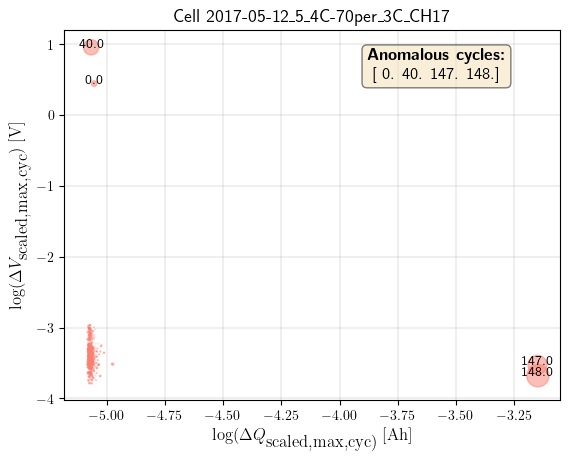

In [28]:
# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=df_features_per_cell["log_max_diff_dQ"],
    yseries=df_features_per_cell["log_max_diff_dV"],
    bubble_size=bubble_size,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=true_outlier_cycle_index)

axplot.set_title(
    f"Cell {selected_cell_label}", fontsize=13)

axplot.set_xlabel(
    r"$\log(\Delta Q_\textrm{scaled,max,cyc)}\;\textrm{[Ah]}$",
    fontsize=12)
axplot.set_ylabel(
    r"$\log(\Delta V_\textrm{scaled,max,cyc})\;\textrm{[V]}$",
    fontsize=12)

output_fig_filename = (
    "log_bubble_plot_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir.joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=200,
    bbox_inches="tight")

plt.show()